## Problem statement

The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. 


The steps to be performed for the first task are given below.

- Exploratory data analysis
- Data cleaning
- Text preprocessing
- Feature extraction: In order to extract features from the text data, you may choose from any of the methods, including bag-of-words, TF-IDF vectorization or word embedding.
- Training a text classification model: You need to build at least three ML models. You then need to analyse the performance of each of these models and choose the best model. At least three out of the following four models need to be built (Do not forget, if required, handle the class imbalance and perform hyperparameter tuning.). 
    1. Logistic regression
    2. Random forest
    3. XGBoost
    4. Naive Bayes
 
Out of these four models, you need to select one classification model based on its performance.

Building a recommendation system
As you learnt earlier, you can use the following types of recommendation systems.
1. User-based recommendation system
2. Item-based recommendation system

Your task is to analyse the recommendation systems and select the one that is best suited in this case. 

Once you get the best-suited recommendation system, the next task is to recommend 20 products that a user is most likely to purchase based on the ratings. <br/>

You can use the 'reviews_username' (one of the columns in the dataset) to identify your user. 
- Improving the recommendations using the sentiment analysis model

Now, the next task is to link this recommendation system with the sentiment analysis model that was built earlier (recall that we asked you to select one ML model out of the four options). Once you recommend 20 products to a particular user using the recommendation engine, you need to filter out the 5 best products based on the sentiments of the 20 recommended product reviews. 

In this way, you will get an ML model (for sentiments) and the best-suited recommendation system. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

import pickle
import os

import xgboost as xgb
from numpy import *

In [2]:
%matplotlib inline

In [3]:
# NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng') 
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import string
from wordcloud import WordCloud

from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aswan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aswan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\aswan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aswan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aswan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
import warnings

warnings.filterwarnings("ignore") 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 400)
pd.set_option("display.precision", 2)

In [5]:
from sklearn.linear_model import LogisticRegression
import time

# **Task 1: Data Cleaning and Pre-Processing**

In [159]:
# Loading the dataset
ebuss_df = pd.read_csv("sample30.csv")
ebuss_df.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


In [160]:
ebuss_df.shape

(30000, 15)

In [161]:
ebuss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [162]:
ebuss_df.nunique()

id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64

In [163]:
# Calculates the percentage of missing values in each column of a DataFrame.
# Args:
#   X (pandas.DataFrame): The input DataFrame.
# Returns:
#   pandas.DataFrame: A DataFrame containing the percentage of missing values for each column, sorted in descending order.
def get_missing_value_percentage(X):
  percent_missing = round((X.isnull().sum() / X.isnull().count()*100),3).to_frame('missing_percentage').sort_values('missing_percentage',ascending = False)
  return percent_missing

In [164]:
get_missing_value_percentage(ebuss_df)

,missing_percentage
reviews_userProvince,9.94e+01
reviews_userCity,9.36e+01
reviews_didPurchase,4.69e+01
reviews_doRecommend,8.57e+00
reviews_title,6.33e-01
manufacturer,4.70e-01
reviews_username,2.10e-01
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00


#### ***Observations*** ####

Here are the key takeaway's from the above results:
* There are 30000 rows
* Total of 271 unique products
* Total Categories - 270
* There are 24914 users
* Three fields are there in the dataset which are having more than 40% of missing values(reviews_userProvince, reviews_userCity, reviews_didPurchase)

### Drop the columns with more than 40% of missing values
Dropping columns `reviews_userProvince`, `reviews_userCity`, `reviews_didPurchase`

In [165]:
ebuss_df.drop(columns=["reviews_userProvince", "reviews_userCity", "reviews_didPurchase"],inplace=True)
get_missing_value_percentage(ebuss_df)

,missing_percentage
reviews_doRecommend,8.57e+00
reviews_title,6.33e-01
manufacturer,4.70e-01
reviews_username,2.10e-01
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00
brand,0.00e+00
categories,0.00e+00
name,0.00e+00


In [166]:
round(ebuss_df[["reviews_doRecommend"]].value_counts(normalize=True) * 100, 2)

reviews_doRecommend
True                   94.35
False                   5.65
Name: proportion, dtype: float64

**As this `reviews_doRecommend` is skewed and will not help in analysis, we should drop this column**

In [167]:
ebuss_df_clean = ebuss_df.drop(columns=['reviews_doRecommend'])
get_missing_value_percentage(ebuss_df_clean)

,missing_percentage
reviews_title,6.33e-01
manufacturer,4.70e-01
reviews_username,2.10e-01
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00
brand,0.00e+00
categories,0.00e+00
name,0.00e+00
reviews_rating,0.00e+00


### Nil value treatment
- `reviews_title` has only 0.6% of nil values. Replacing the the value with `unknown`
- `reviews_username` has only 0.2% of nil values. Replacing the the value with `unknown`

In [168]:
ebuss_df_clean['reviews_title'].fillna('unknown',inplace=True)
ebuss_df_clean['reviews_username'].fillna('unknown',inplace=True)
get_missing_value_percentage(ebuss_df_clean)

,missing_percentage
manufacturer,4.70e-01
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00
brand,0.00e+00
categories,0.00e+00
name,0.00e+00
reviews_rating,0.00e+00
reviews_text,0.00e+00
reviews_title,0.00e+00


In [169]:
# Gets a list of column values whose cumulative frequency is less than or equal to a given threshold.
# Args:
#   df (pandas.DataFrame): The input DataFrame.
#   column_name (str): The name of the column to analyze.
#   threshold (float): The threshold value for cumulative frequency.
# Returns:
#   list: A list of column values whose cumulative frequency is less than or equal to the threshold.
def get_columns_with_cumfreq(df, column_name,threshold):
    df_cat_freq = df[column_name].value_counts()
    df_cat_freq = pd.DataFrame({'column':df_cat_freq.index, 'value':df_cat_freq.values})
    df_cat_freq['perc'] = df_cat_freq['value'].cumsum()/df_cat_freq['value'].sum()
    return list(df_cat_freq.loc[df_cat_freq['perc']<=threshold].column)

#### `manufacturer` coulmn treatment.
- Get the top 95% of manufacturer
- Replace the remaining manufacturer with others

In [170]:
top_manufacturers = get_columns_with_cumfreq(ebuss_df_clean, "manufacturer", 0.95)

# all the levels below 95 percentage are assgined to a single level called others
# get rows for levels which are not present in top_manufacturer_list
ebuss_new_df = ebuss_df_clean[~ebuss_df_clean['manufacturer'].isin(top_manufacturers)]

# replace the value of these levels to others
ebuss_new_df['manufacturer'] = "others"

# get rows for levels which are present in list_platform
ebuss_old_df = ebuss_df_clean[ebuss_df_clean['manufacturer'].isin(top_manufacturers)]

# concatenate new_df and old_df to get the final dataframe
ebuss_df_clean_updated = pd.concat([ebuss_new_df, ebuss_old_df])

get_missing_value_percentage(ebuss_df_clean_updated)

,missing_percentage
reviews_date,1.53e-01
user_sentiment,3.00e-03
id,0.00e+00
brand,0.00e+00
categories,0.00e+00
manufacturer,0.00e+00
name,0.00e+00
reviews_rating,0.00e+00
reviews_text,0.00e+00
reviews_title,0.00e+00


#### `review_date` nil value treatment
- Convert to date type
- Drop the missing rows for this column as just 0.15% is missing

In [171]:
#converting 'reviews_date' to date time object
ebuss_df_clean_updated["reviews_date"] = pd.to_datetime(ebuss_df_clean_updated["reviews_date"], errors='coerce')
ebuss_df_clean_updated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                30000 non-null  object             
 1   brand             30000 non-null  object             
 2   categories        30000 non-null  object             
 3   manufacturer      30000 non-null  object             
 4   name              30000 non-null  object             
 5   reviews_date      29255 non-null  datetime64[ns, UTC]
 6   reviews_rating    30000 non-null  int64              
 7   reviews_text      30000 non-null  object             
 8   reviews_title     30000 non-null  object             
 9   reviews_username  30000 non-null  object             
 10  user_sentiment    29999 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(9)
memory usage: 2.7+ MB


In [172]:
ebuss_df_clean_updated = ebuss_df_clean_updated[~ ebuss_df_clean_updated['reviews_date'].isna()]
get_missing_value_percentage(ebuss_df_clean_updated)

,missing_percentage
user_sentiment,3.00e-03
id,0.00e+00
brand,0.00e+00
categories,0.00e+00
manufacturer,0.00e+00
name,0.00e+00
reviews_date,0.00e+00
reviews_rating,0.00e+00
reviews_text,0.00e+00
reviews_title,0.00e+00


#### `user_sentiment` nil value treatment
- This column is skewed with most values as Positive
- Replace nil with Positive

In [173]:
round(ebuss_df_clean_updated.user_sentiment.value_counts(normalize=True) * 100, 2)

user_sentiment
Positive    88.8
Negative    11.2
Name: proportion, dtype: float64

In [174]:
ebuss_df_clean_updated['user_sentiment'].fillna('Positive', inplace=True)
get_missing_value_percentage(ebuss_df_clean_updated)

,missing_percentage
id,0.0
brand,0.0
categories,0.0
manufacturer,0.0
name,0.0
reviews_date,0.0
reviews_rating,0.0
reviews_text,0.0
reviews_title,0.0
reviews_username,0.0


In [175]:
ebuss_df_clean_updated['user_sentiment'] = ebuss_df_clean_updated['user_sentiment'].map({'Positive':1,'Negative':0})

## Exploratory Data Analysis

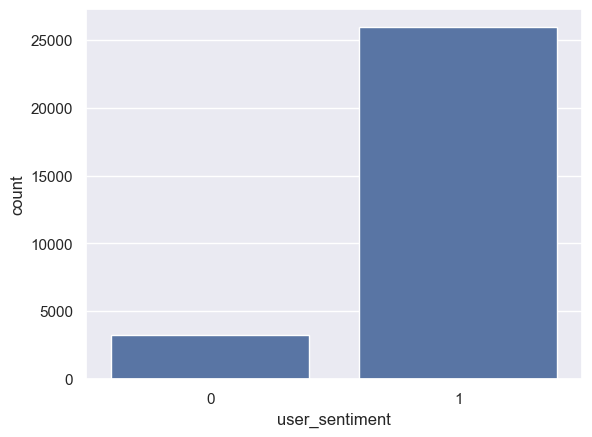

In [176]:
sns.countplot(x='user_sentiment', data = ebuss_df_clean_updated)
plt.show()

### Review feature distribution
- Almost `90%` of the ratings are either 4 star or 5 star

In [177]:
round(ebuss_df_clean_updated["reviews_rating"].value_counts(normalize=True) * 100, 2)

reviews_rating
5    69.49
4    20.23
1     4.51
3     4.45
2     1.33
Name: proportion, dtype: float64

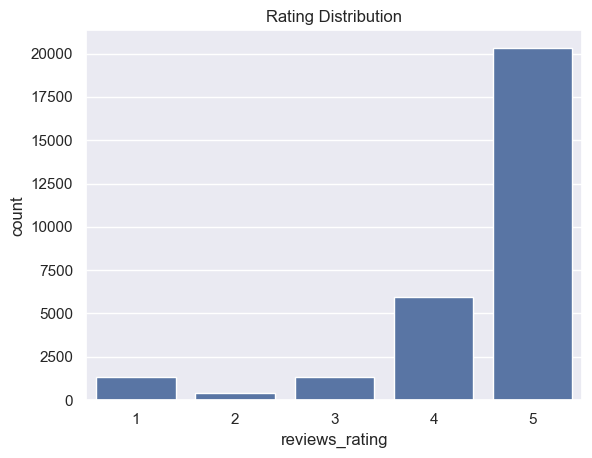

In [178]:
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated).set_title("Rating Distribution")
plt.show()

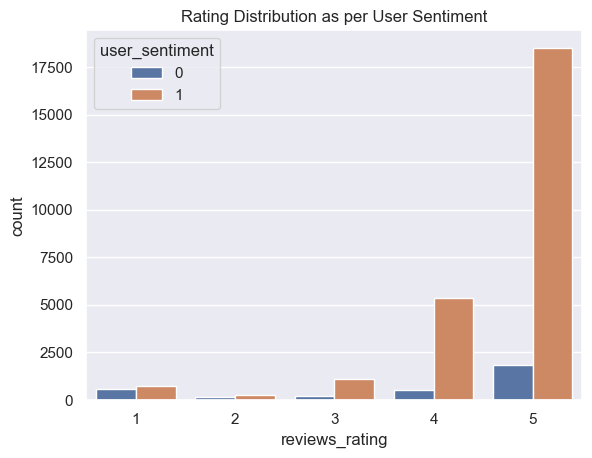

In [179]:
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated, hue="user_sentiment").set_title("Rating Distribution as per User Sentiment")
plt.show()

#### Products rating with negative Sentiment
- Around 70+% of negative sentiments has 4 or 5 star ratings

In [180]:
round(ebuss_df_clean_updated[ebuss_df_clean_updated["user_sentiment"] == 0]["reviews_rating"].value_counts(normalize=True) * 100, 2)

reviews_rating
5    55.69
1    17.33
4    16.48
3     6.50
2     4.00
Name: proportion, dtype: float64

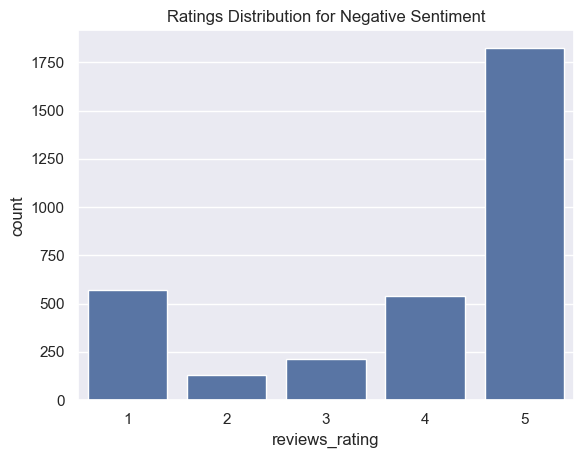

In [181]:
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated[ebuss_df_clean_updated["user_sentiment"] == 0]).set_title("Ratings Distribution for Negative Sentiment")
plt.show()

#### Products rating with positive Sentiment
- Around 8% of positive sentiments are less than 4 star

In [182]:
round(ebuss_df_clean_updated[ebuss_df_clean_updated["user_sentiment"] == 1]["reviews_rating"].value_counts(normalize=True) * 100, 2)

reviews_rating
5    71.23
4    20.70
3     4.20
1     2.89
2     0.99
Name: proportion, dtype: float64

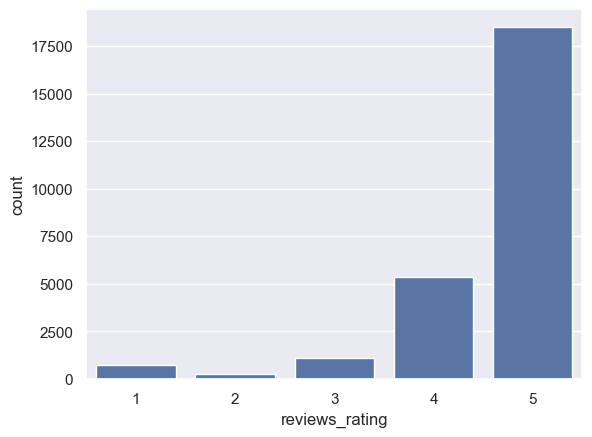

In [183]:
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated[ebuss_df_clean_updated["user_sentiment"] == 1])
plt.show()

#### Understanding the `user_sentiment` feature values
- Many Review with 4 or more stars will be assigned Positive sentiment
- Many Review with less than 4 star will be assigned negative sentiment

#### Samples with negative user sentiment but reviews 4 star or more

In [184]:
print(ebuss_df_clean_updated[(ebuss_df_clean_updated["user_sentiment"] == 0) & (ebuss_df_clean_updated["reviews_rating"] >= 4)].shape)
ebuss_df_clean_updated[(ebuss_df_clean_updated["user_sentiment"] == 0) & (ebuss_df_clean_updated["reviews_rating"] >= 4)][["name", "reviews_title", "reviews_text", "reviews_rating"]].sample(10)


(2365, 11)


,name,reviews_title,reviews_text,reviews_rating
19830,Clorox Disinfecting Bathroom Cleaner,Tough enough for my family,"I loooove these wipes. They not only get rid of dirty finger prints left behind but leaves my house smelling clean. With their quilted pattern, it helps pick up dirt. A must in my house!",5
11379,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Wipes,When flu season hits Clorox wipes are our go to at home and at work. This review was collected as part of a promotion.,5
26952,Jason Aldean - They Don't Know,Amazing,Jason Andean come through again. Melodies are catchy and will have you singing along well after the cd has stopped.,5
27153,"Vicks Vaporub, Regular, 3.53oz",Uses I have found it helps,"I have used it for the infection from ingrown toe nails. It draws the infection and swelling out, so that it can be clipped out. I also use it to draw the infection from boils out. Just put it on then cover with a bandage.Use every night till boil opens.",5
7417,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,have kids need these wipes,I can not imagine life without these with the kids... This review was collected as part of a promotion.,4
26038,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,interesting,"though was a remake of old one I didn't expect much, was I wrong",5
11650,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Convenient and disinfects,I have a toddler and a baby on the way. I like Clorox wipes to use on the go for wiping off highchairs and all over in hotel rooms. I also use them at home for wiping off door handles and remotes periodically especially after we've had a cold. This review was collected as part of a promotion.,5
13718,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Great Product,I use these wipes all the time. They are so convenient especially when someone in the house is sick. I will continue to use these. This review was collected as part of a promotion.,5
2011,Mike Dave Need Wedding Dates (dvd + Digital),So Bad... SO GOOD!,"This movie is outrageous, inappropriate, PC incorrect, raunchy stupid slapstick, so over the top that it shouldn't work but, by some miracle mixed with such enthusiastic commitment from everyone involved, this thing fires on all cylinders. It has the same OMG powerhouse energy of classics like THERE'S SOMETHING ABOUT MARY. Forget credibility and good taste, surrender to its shocking insanity, ...",4
12482,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Winter Must-Have,I could not get through cold and flu season without it! This review was collected as part of a promotion.,5


#### Samples with positive user sentiment but reviews less than 4 stars

In [185]:
print(ebuss_df_clean_updated[(ebuss_df_clean_updated["user_sentiment"] == 1) & (ebuss_df_clean_updated["reviews_rating"] < 4)].shape)
ebuss_df_clean_updated[(ebuss_df_clean_updated["user_sentiment"] == 1) & (ebuss_df_clean_updated["reviews_rating"] < 4)][["name", "reviews_title", "reviews_text", "reviews_rating"]].sample(10)


(2097, 11)


,name,reviews_title,reviews_text,reviews_rating
28931,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,good for combination hair but not into the scent,received from influenster as a freebie for testing purposes. ive been going through a handful of color treatments this year so my super long soft and shiny hair is now damaged and dry at the ends. i also normally wash my hair every 36-48 hours normally as my scalp gets irritated and dry if i wash daily. used this conditioner as a 3rd step to the whole extraordinary clay system (mask + shampoo)...,3
21433,Nexxus Exxtra Gel Style Creation Sculptor,New Formula,"As other customers have indicated, the new formula is of far inferior quality compared to the previous version. I read on this page that there will be an adjustment to return to a tweaked version of the older formula. Can you provide a time frame for this I have been a loyal customer for a decade, and I really abhor the idea of having to test other brands to find a replacement.",1
17320,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",Best of what I have tried to date.,"Works best of the products I have tried, though I have not tried the newest product your company offers. Autostop.. However it does not seem to last very long.. and I become lazy on the next application, and the cost involved.",2
28873,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,Meh Product,Received this product from Influenster to test in addition to the pre-shampoo mask and shampoo. I used all three products together and it was too drying even though i have an oily scalp. The product smelled great and I loved the color of the product packaging but overall it was very disappointing and lackluster. Not L'Oreal's best. This review was collected as part of a promotion.,2
18227,"L'oreal Paris Colour Caresse Wet Shine Stain, Pink Resistance",Lacquer indeed...,"I got to hand it to L'Oreal... they named this product perfectly. What do you call a lip colour that isn't a gloss or stain or balm or lipstick One that, upon application, seems to immediately draw all the moisture out of your lips and leave you with a tacky finish similar to drying paint Lacquer! Marketing at its finest. Yes, the packaging is eye-catching, but the applicator (think disposable...",1
16790,"Lundberg Wehani Rice, 25lb",So So,"I am trying to reduce the amount of Pesticides Herbicides in my diet, so I have been looking for Organic products and trying to avoid GMO since they are usually engineered to survive heavy dousing with Herbicides (Monsatan calls it Rndup Ready, like it is a good thing). Anyway, I enjoy sushi at home and have tried several brands of quality sushi rice in my Zojirushi cooker. This rice seemed no...",3
15765,"Burt's Bees Lip Shimmer, Raisin",To shimmery!,It was too shimmery and made me feel like I was wearing a child's chapstick. The color was fine but if the sparkle was toned down I would have no problems with it.,2
21916,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",new Caress bar soaps' smell is way too strong,The new versions of Caress bar soap smell way to strong - they stunk up our whole house. I had to wrap them in plastic and give them to a homeless shelter. Please go back to the wonderful original scent.,1
2634,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Funny,"Personally loved the first movie of this series, still fun to see the entire cast back to play the sequel though!",3
26468,"Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Something Makes My Eyes Burn,"I have used Aveeno products for years, but I started to notice my eyes burn almost all day. At first I thought it was due to allergies, but I started noticing the burning sensation immediately after using the product, and have not been outside yet.",1


In [186]:
pd.crosstab(ebuss_df_clean_updated["user_sentiment"], ebuss_df_clean_updated["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,568,131,213,540,1825,3277
1,750,257,1090,5378,18503,25978
All,1318,388,1303,5918,20328,29255


#### `user_sentiment` value correction
- Positve with less than 4 rating will be assigned as negative
- Negative with 4 or more rating will be assigned positive

In [187]:
ebuss_df_clean_updated.loc[(ebuss_df_clean_updated["user_sentiment"]==1) & (ebuss_df_clean_updated["reviews_rating"]<4), "user_sentiment"] = 0
ebuss_df_clean_updated.loc[(ebuss_df_clean_updated["user_sentiment"]==0) & (ebuss_df_clean_updated["reviews_rating"]>=4), "user_sentiment"] = 1

In [188]:
pd.crosstab(ebuss_df_clean_updated["user_sentiment"], ebuss_df_clean_updated["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,1318,388,1303,0,0,3009
1,0,0,0,5918,20328,26246
All,1318,388,1303,5918,20328,29255


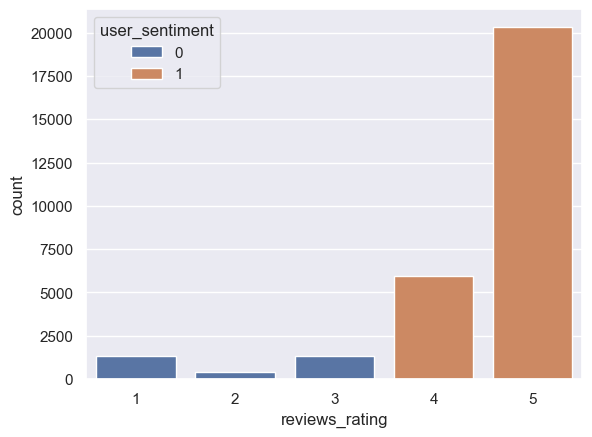

In [189]:
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated, hue="user_sentiment")
plt.show()

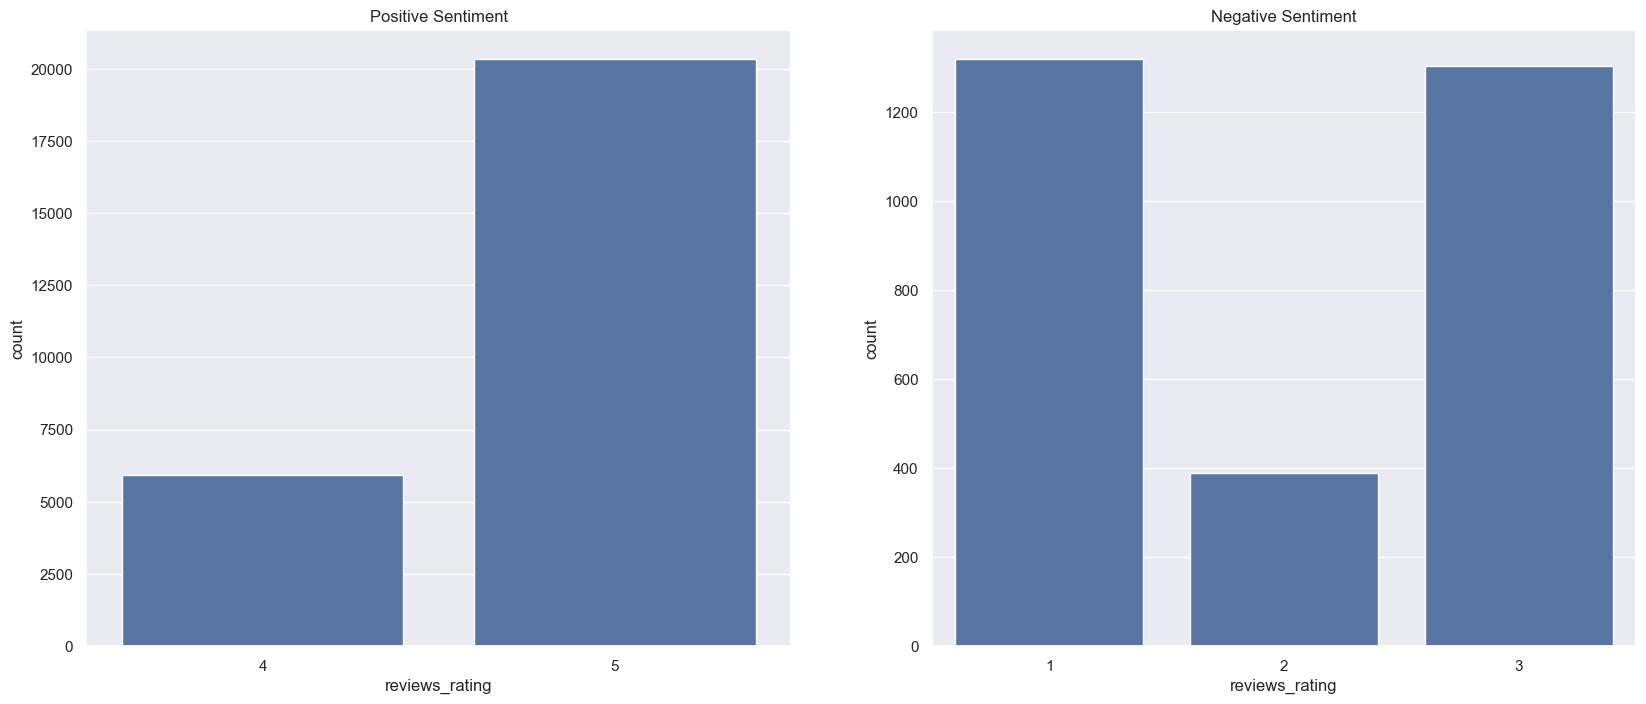

In [190]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ax1.title.set_text("Positive Sentiment")
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated[ebuss_df_clean_updated["user_sentiment"] == 1], ax=ax1)
ax2.title.set_text("Negative Sentiment")
sns.countplot(x='reviews_rating', data = ebuss_df_clean_updated[ebuss_df_clean_updated["user_sentiment"] == 0], ax=ax2)
plt.show()

In [191]:
round(ebuss_df_clean_updated.user_sentiment.value_counts(normalize=True) * 100, 2)

user_sentiment
1    89.71
0    10.29
Name: proportion, dtype: float64

### **Observations - user_sentiment**
- There was some incorrect user_sentiment which was corrected by providing the right value for user sentiment
- user_sentiment is skewed - 89.7% positive
- Rows with 1-3 rating is given negative user_sentiment
- Rows with 4 and above rating is given positive user_sentiment

### **Understand the brand column**

Brand distribution with respect to user sentiment

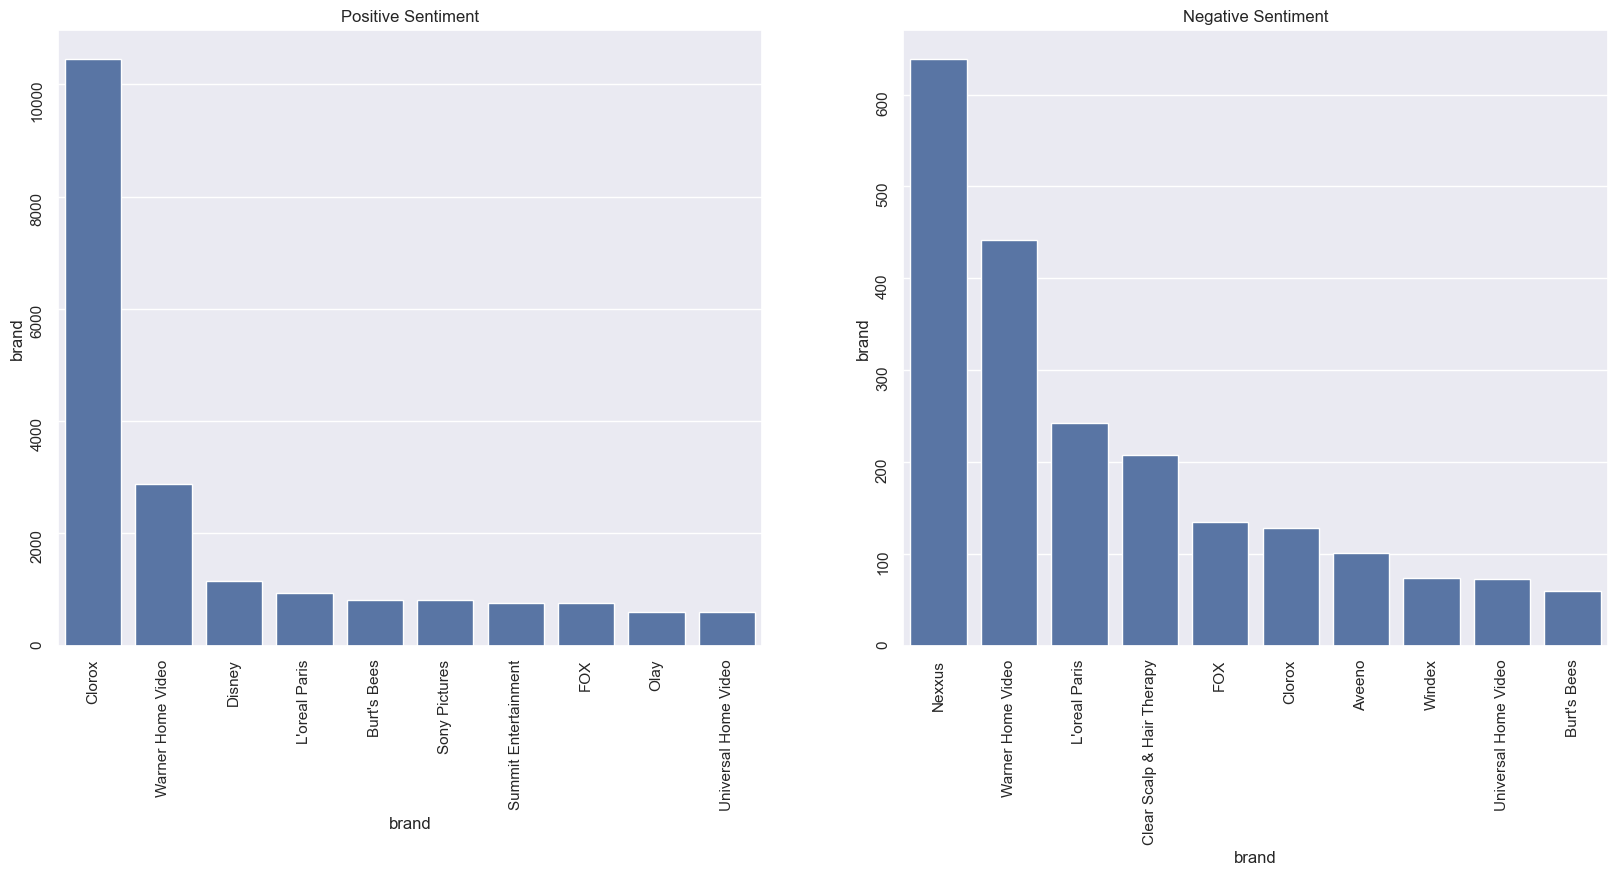

In [192]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
# plt.xticks(rotation=90)

# Filter the top 10 brands among the positive sentiments
sns.barplot(data=ebuss_df_clean_updated[ebuss_df_clean_updated['user_sentiment']==1].groupby('brand')['brand'].count().sort_values(ascending=False)[:10], ax=ax1)
ax1.tick_params(labelrotation=90)
ax1.title.set_text("Positive Sentiment")

sns.barplot(data=ebuss_df_clean_updated[ebuss_df_clean_updated['user_sentiment']==0].groupby('brand')['brand'].count().sort_values(ascending=False)[:10], ax=ax2)
ax2.title.set_text("Negative Sentiment")
ax2.tick_params(labelrotation=90)

plt.show()

### **Observation - Analysing features**
- Clorox brand has the maximum positive reviews
- Nexxus brand has the maximum negative reviews
- `89.71%` rows contains positive sentiment and just `10.29%` rows contains negative sentiment - **This could result in class imbalance problem**

#### Item level user sentiment

In [193]:
def filter_products(df, productId, pos=1):
    review_count = df[(df.id==productId) & (df.user_sentiment==pos)]['brand'].count()
    return review_count

In [194]:
#group the dataframe by product id and view the # of pos review / neg reviews count
ebuss_custom =  ebuss_df_clean_updated.groupby('id', as_index=False)['user_sentiment'].count()
ebuss_custom["pos_review_count"] =  ebuss_custom.id.apply(lambda id: filter_products(ebuss_df_clean_updated, id, 1))
ebuss_custom["neg_review_count"] =  ebuss_custom.id.apply(lambda id: filter_products(ebuss_df_clean_updated, id, 0))

In [195]:
ebuss_custom.sort_values(by=['user_sentiment'], ascending=False).head(10)

,id,user_sentiment,pos_review_count,neg_review_count
81,AVpf3VOfilAPnD_xjpun,8545,8447,98
165,AVpfPaoqLJeJML435Xk9,3325,2883,442
142,AVpfJP1C1cnluZ0-e3Xy,2039,2009,30
184,AVpfW8y_LJeJML437ySW,1186,944,242
173,AVpfRTh1ilAPnD_xYic2,1142,1092,50
90,AVpf63aJLJeJML43F__Q,873,814,59
74,AVpf0eb2LJeJML43EVSt,845,812,33
35,AVpe41TqilAPnD_xQH3d,757,631,126
211,AVpfm8yiLJeJML43AYyu,685,46,639
79,AVpf2tw1ilAPnD_xjflC,669,645,24


**Sorted based on positive user_sentiments received**

In [196]:
ebuss_custom.sort_values(by=['pos_review_count'], ascending=False).head(10)

,id,user_sentiment,pos_review_count,neg_review_count
81,AVpf3VOfilAPnD_xjpun,8545,8447,98
165,AVpfPaoqLJeJML435Xk9,3325,2883,442
142,AVpfJP1C1cnluZ0-e3Xy,2039,2009,30
173,AVpfRTh1ilAPnD_xYic2,1142,1092,50
184,AVpfW8y_LJeJML437ySW,1186,944,242
90,AVpf63aJLJeJML43F__Q,873,814,59
74,AVpf0eb2LJeJML43EVSt,845,812,33
79,AVpf2tw1ilAPnD_xjflC,669,645,24
35,AVpe41TqilAPnD_xQH3d,757,631,126
24,AV1l8zRZvKc47QAVhnAv,634,597,37


**Sorted based on negative user_sentiments received**

In [197]:
ebuss_custom.sort_values(by=['neg_review_count'], ascending=False).head(10)

,id,user_sentiment,pos_review_count,neg_review_count
211,AVpfm8yiLJeJML43AYyu,685,46,639
165,AVpfPaoqLJeJML435Xk9,3325,2883,442
184,AVpfW8y_LJeJML437ySW,1186,944,242
161,AVpfOmKwLJeJML435GM7,370,163,207
35,AVpe41TqilAPnD_xQH3d,757,631,126
164,AVpfPPkEilAPnD_xX3cP,270,169,101
81,AVpf3VOfilAPnD_xjpun,8545,8447,98
3,AV1YGDqsGV-KLJ3adc-O,348,274,74
38,AVpe59io1cnluZ0-ZgDU,668,596,72
90,AVpf63aJLJeJML43F__Q,873,814,59


**Products with only positive sentiment**

In [198]:
#sort the product by sentiment % - postive reviews / total number of reviews
ebuss_custom['sentiment %'] = np.round((ebuss_custom['pos_review_count']/ebuss_custom['user_sentiment'])*100,2)
ebuss_custom.sort_values(by=['sentiment %', 'pos_review_count'], ascending=False).head(10)

,id,user_sentiment,pos_review_count,neg_review_count,sentiment %
49,AVpe6FpaLJeJML43yBuP,68,68,0,100.0
8,AV1Ymf_rglJLPUi8II2v,34,34,0,100.0
73,AVpf0YhQLJeJML43ETff,34,34,0,100.0
170,AVpfQtEm1cnluZ0-hUpe,27,27,0,100.0
193,AVpfe3On1cnluZ0-lgn5,20,20,0,100.0
141,AVpfIvbgLJeJML433Kph,17,17,0,100.0
54,AVpe7GIELJeJML43yZfu,15,15,0,100.0
31,AVpe-ltS1cnluZ0-bL8w,13,13,0,100.0
227,AVpfrfHF1cnluZ0-pRai,13,13,0,100.0
107,AVpfBpnEilAPnD_xTUBx,11,11,0,100.0


**Products with only positive sentiment**

In [199]:
#sort the product by sentiment % - postive reviews / total number of reviews
ebuss_custom['sentiment %'] = np.round((ebuss_custom['neg_review_count']/ebuss_custom['user_sentiment'])*100,2)
ebuss_custom.sort_values(by=['sentiment %', 'neg_review_count'], ascending=False).head(10)

,id,user_sentiment,pos_review_count,neg_review_count,sentiment %
30,AVpe-YAL1cnluZ0-bHGh,1,0,1,100.0
34,AVpe4-GPLJeJML43xmuY,1,0,1,100.0
45,AVpe625_ilAPnD_xQ4SP,1,0,1,100.0
46,AVpe6C3WLJeJML43yApY,1,0,1,100.0
61,AVpe8q4T1cnluZ0-afct,1,0,1,100.0
111,AVpfC3KoLJeJML431KRR,1,0,1,100.0
121,AVpfDflP1cnluZ0-c5RJ,1,0,1,100.0
124,AVpfE7puilAPnD_xUcCW,1,0,1,100.0
129,AVpfF7k8ilAPnD_xUyWf,1,0,1,100.0
137,AVpfHZMxLJeJML432tfs,1,0,1,100.0


# **Task 2: Text Processing**

### **Helper functions**

In [48]:
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [49]:
stop_words = set(stopwords.words('english'))

In [50]:
def remove_stopword(text):
    words = [word for word in text.split() if word.isalpha() and word not in stop_words]
    return " ".join(words)

In [51]:
# Lemmatizes a given text
lemmatizer = WordNetLemmatizer()
# Lemmatize the sentence
def lemma_text(text):
    word_pos_tags = nltk.pos_tag(word_tokenize(remove_stopword(text))) # Get position tags
    # Map the position tag and lemmatize the word/token
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(words)

### **Preprocessing the ReviewsTitle and ReviewText**
- Add a new column `reviews_preprocess_text` with value join of `reviews_title` and `reviews_text`

**Preprocessing**
- Remove stopwords

**Lematization**
- Add a new column `reviews_complete_text`
- Reduce words to it's lemma form

In [52]:
ebuss_df_clean_updated["reviews_preprocess_text"] = ebuss_df_clean_updated[['reviews_title', 'reviews_text']].agg(' '.join, axis=1).str.lstrip('. ')

# Lematization
ebuss_df_clean_updated["reviews_complete_text"] = ebuss_df_clean_updated["reviews_preprocess_text"].apply(lemma_text)

In [53]:
ebuss_df_clean_updated.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_preprocess_text,reviews_complete_text
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",others,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome love hip hop side current pop SO listen everyday give rating metaphor
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",others,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1,Good Good flavor. This review was collected as part of a promotion.,Good Good This review collect part
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",others,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5,Good flavor.,Good,dorothy w,1,Good Good flavor.,Good Good
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",others,K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00+00:00,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was ...",Disappointed,rebecca,0,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vase...",Disappointed I read review look buy one couple ultimately disappointed even live review I For neither boyfriend I could notice sort enhance What messy consistency reminiscent It difficult clean especially since lack sensation disappoint I pay much I lube I use I could use normal personal lubricant less money less
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",others,K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00+00:00,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation My husband buy gel The gel cause irritation felt like burn I recommend


### Save the Preprocessed the dataframe using pickel

In [54]:
def save_object_to_pickle(obj, file_name):
    """Saves a given object(dataframe or model or anyother obj)  to a pickle file in a directory.

    The directory name is derived from the file name. If the directory
    does not exist, it is created.

    Args:
        obj (obj): dataframe or model or anyother obj to save.
        file_name (str): The name of the file (without extension).
    """
    dir_name = "pickle_files"  # Create directory name
    if not os.path.exists(dir_name):
        try:
            os.makedirs(dir_name)
            print(f"Directory '{dir_name}' created successfully.")
        except OSError as e:
            print(f"Error creating directory '{dir_name}': {e}")
            return  # Stop if directory creation fails

    file_path = os.path.join(dir_name, file_name + ".pkl")  # Full file path
    try:
        pd.to_pickle(obj, file_path)  
        print(f"Object successfully saved to: {file_path}")
    except Exception as e:
        print(f"An error occurred while saving the DataFrame: {e}")

In [55]:
save_object_to_pickle(ebuss_df_clean_updated, 'preprocessed-dataframe')

Object successfully saved to: pickle_files\preprocessed-dataframe.pkl


# **Task 3: Feature Extraction**

Create WordCloud to check on Top 50 words

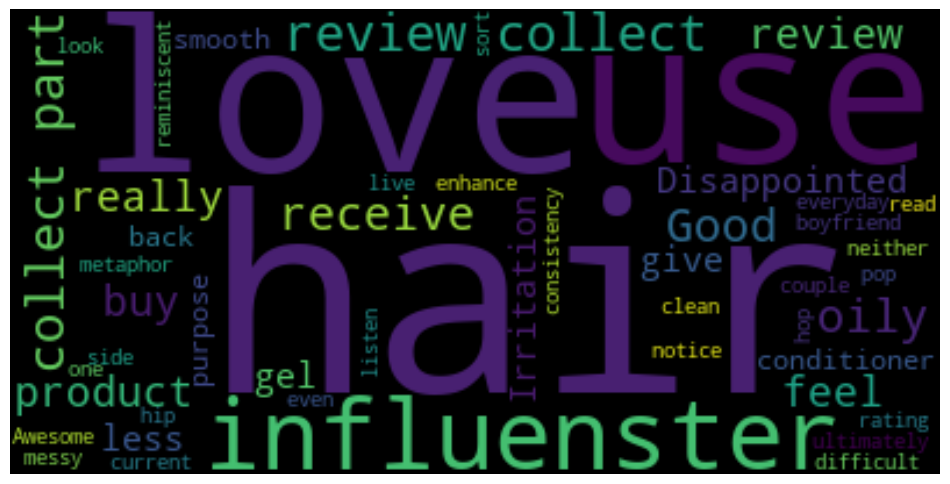

In [56]:
wordcloud = WordCloud(max_words=50, random_state=42)
wordcloud.generate(str(ebuss_df_clean_updated['reviews_complete_text']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [57]:
words_per_review = ebuss_df_clean_updated['reviews_complete_text'].apply(lambda x: len(x.split(" ")))
print('Average words per Review:', round(words_per_review.mean(),2))

Average words per Review: 18.26


In [58]:
# Gets the top N most frequent n-grams from a given corpus.
# Args:
#     corpus (list): A list of text documents.
#     n_gram_range (int): The range of n-grams to consider.
#     n (int, optional): The number of top n-grams to return. Defaults to None, which returns all n-grams.
# Returns:
#     list: A list of tuples, where each tuple contains an n-gram and its frequency.
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    # Create a CountVectorizer to count the frequency of n-grams
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    
    # Transform the corpus into a bag-of-words representation
    bag_of_words = vec.transform(corpus)

    # Sum the frequencies of each n-gram across all documents
    sum_words = bag_of_words.sum(axis=0)    # --1: Calculate the sum of frequencies for each n-gram 
    # print("--1",sum_words)

    # Get the first word and its index to break the loop
    for word, idx in vec.vocabulary_.items():
        break

    # Create a list of tuples, where each tuple contains an n-gram and its frequency
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # Sort the list of tuples by frequency in descending order
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    # Return the top N n-grams
    return words_freq[:n]

#### Top 10 words in the unigram frequency

In [59]:
common_words = get_top_n_ngram(ebuss_df_clean_updated['reviews_complete_text'], 1, 10)
pd.DataFrame(common_words)

,0,1
0,great,12935
1,love,12093
2,use,11778
3,review,9201
4,product,8854
5,collect,8767
6,movie,7723
7,clean,6484
8,good,6158
9,clorox,5599


#### Top 10 words in the bigram frequency

In [60]:
common_words = get_top_n_ngram(ebuss_df_clean_updated['reviews_complete_text'], 2, 10)
pd.DataFrame(common_words)

,0,1
0,review collect,8743
1,clorox wipe,1587
2,great movie,1349
3,great product,1261
4,love clorox,1119
5,use clorox,1038
6,love use,971
7,easy use,964
8,love love,789
9,use product,784


#### Top 10 words in the trigram frequency

In [61]:
common_words = get_top_n_ngram(ebuss_df_clean_updated['reviews_complete_text'], 3, 10)
pd.DataFrame(common_words)

,0,1
0,clean review collect,552
1,use review collect,412
2,use clorox wipe,412
3,love use clorox,254
4,love review collect,244
5,opinion review collect,235
6,great movie great,229
7,great review collect,228
8,smell review collect,227
9,receive product free,218


### **Observations**
- Highlighted the most occuring words with word cloud
- The average word count per review is 18.26%
- We have extracted all the 1-gram, 2-gram, and 3-gram words

### **Feature extraction & Input and output variable seperation**

In [62]:
# Creating TF-IDF vectorizer, for model building
# Considering all unigram, bigram, trigram words
vectorizer = TfidfVectorizer(max_df=0.95,min_df=5,
                             stop_words='english',
                             tokenizer= word_tokenize,
                             ngram_range=(1,3))

In [63]:
# Fitting the TF-IDF vectorizer on the training set
X_tfidf = vectorizer.fit_transform(ebuss_df_clean_updated['reviews_complete_text'])
y = ebuss_df_clean_updated['user_sentiment']

#### Save Vectorizer Object

In [64]:
# Save Vectorizer Object
save_object_to_pickle(vectorizer, 'tfidf-vectorizer')

Object successfully saved to: pickle_files\tfidf-vectorizer.pkl


In [65]:
print(X_tfidf.shape)
print(y.shape)

(29255, 16523)
(29255,)


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state=42, test_size=0.2)
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)
print("y_train shape =", y_train.shape)
print("y_test shape =", y_test.shape)

X_train shape = (23404, 16523)
X_test shape = (5851, 16523)
y_train shape = (23404,)
y_test shape = (5851,)


### **Implementing SMOTE as user_sentiment is imbalanced**

In [67]:
count = Counter(y_train)
print('Before Applying SMOTE:',count)

sm = SMOTE(random_state = 42)

# transform the dataset
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train.ravel())

count = Counter(y_train_sm)
print('After Applying SMOTE:',count)

Before Applying SMOTE: Counter({1: 20976, 0: 2428})
After Applying SMOTE: Counter({1: 20976, 0: 20976})


# **Task 4: Model Building**

### Helper models

In [68]:
class ModelFactory:
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
        
    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)
    
    def evaluate_model(self, y_pred_class):
        print("\n")
        print("*"*30)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("*"*30)
        print("\n")
        
        self.classification_report(y_pred_class)
        print("*"*30)
        print("\n")
        self.confusion_matrix(y_pred_class)
            
        print("*"*30)
        print("\n")
        
        metrics.RocCurveDisplay.from_estimator(self.model, self.x_test, self.y_test)
        
        return self.result_metrics
        
    def evaluate_metrics(self, y_pred_class):
        result_metrics = [] 
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)
        
        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")
        
        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics
        
    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix,[0,1])
        
        
    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Blues", fmt=".2%")
 
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
 
        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()
        
    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))

### **1. Logistic Regression**

In [69]:
# Build the Logistic Regression model.
%time

logreg_ci = LogisticRegression(random_state=42, max_iter=100,solver='liblinear', class_weight="balanced")
lr_ci_modebuilder = ModelFactory(logreg_ci, X_train, X_test, y_train, y_test)

CPU times: total: 0 ns
Wall time: 0 ns


In [70]:
# Train and Predict the Test Labels
y_pred_class  = lr_ci_modebuilder.train_model()



******************************
Accuracy is : 89.0%
Precision is : 97.6%
Recall is : 90.1%
F1 Score is : 93.7%
Roc-Auc Score is:93.3%
******************************


              precision    recall  f1-score   support

           0       0.47      0.80      0.59       581
           1       0.98      0.90      0.94      5270

    accuracy                           0.89      5851
   macro avg       0.72      0.85      0.76      5851
weighted avg       0.93      0.89      0.90      5851

******************************




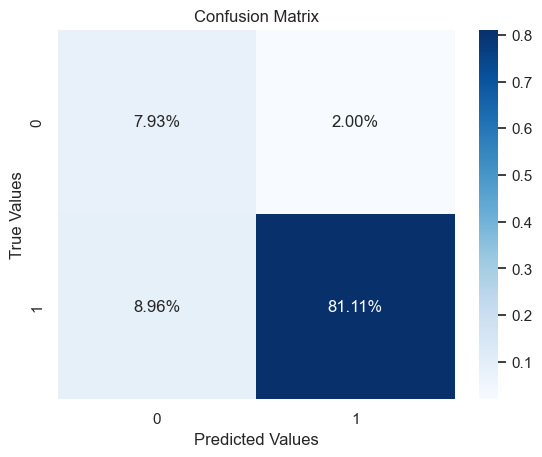

******************************




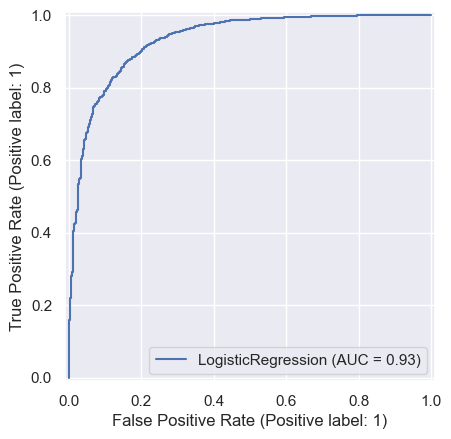

In [71]:
lr_metrics = lr_ci_modebuilder.evaluate_model(y_pred_class)

### **2. Naive Bayes**

In [72]:
mnb = MultinomialNB(alpha=1.0)
mnb_modebuilder = ModelFactory(mnb, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 93.1%
Precision is : 93.2%
Recall is : 99.6%
F1 Score is : 96.3%
Roc-Auc Score is:91.0%
******************************


              precision    recall  f1-score   support

           0       0.90      0.34      0.50       581
           1       0.93      1.00      0.96      5270

    accuracy                           0.93      5851
   macro avg       0.92      0.67      0.73      5851
weighted avg       0.93      0.93      0.92      5851

******************************




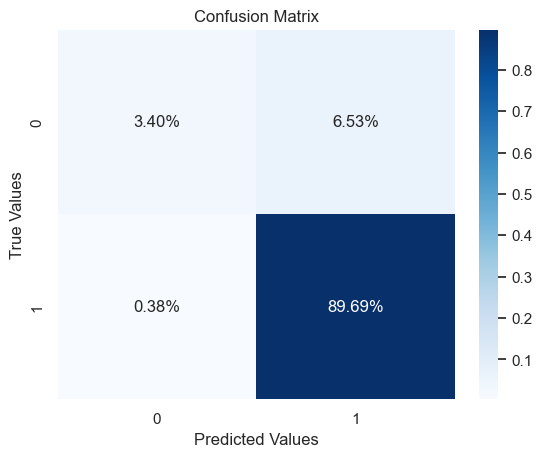

******************************




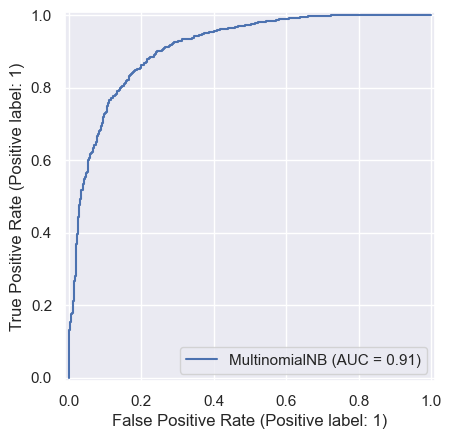

In [73]:
# Train and Predict the Test Labels
y_pred_class  = mnb_modebuilder.train_model()
nb_metrics = mnb_modebuilder.evaluate_model(y_pred_class)

### **3. Decision Tree**

In [74]:
dt = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)

In [75]:
dt_modelbuilder = ModelFactory(dt, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 93.1%
Precision is : 93.5%
Recall is : 99.2%
F1 Score is : 96.3%
Roc-Auc Score is:79.2%
******************************


              precision    recall  f1-score   support

           0       0.84      0.38      0.52       581
           1       0.94      0.99      0.96      5270

    accuracy                           0.93      5851
   macro avg       0.89      0.69      0.74      5851
weighted avg       0.93      0.93      0.92      5851

******************************




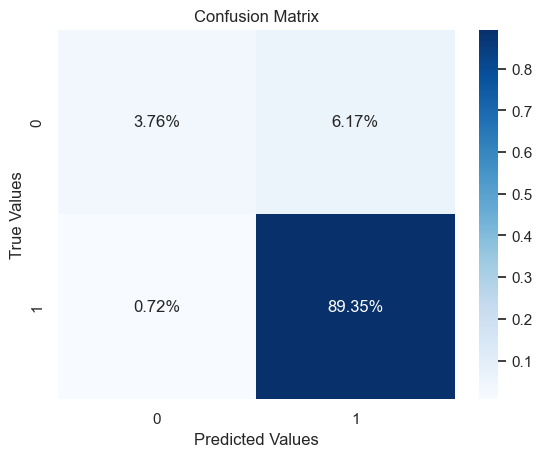

******************************




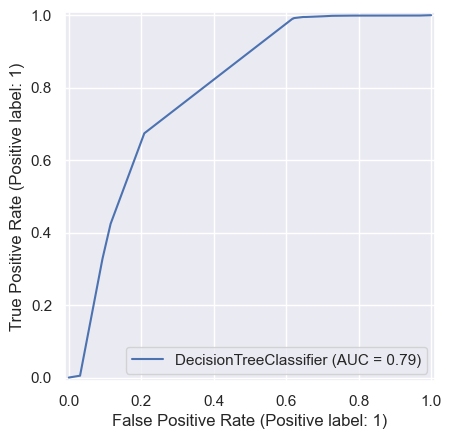

In [76]:
y_pred_class  = dt_modelbuilder.train_model()
dt_metrics_cv = dt_modelbuilder.evaluate_model(y_pred_class)

### **4. Random Forest**

In [77]:
rf = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")

In [78]:
params = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10,20,50],
    'n_estimators': [10, 25, 50, 100]
}

In [79]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1")

In [80]:
%time
grid_search.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 4 folds for each of 64 candidates, totalling 256 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='f1', verbose=1)

In [81]:
rf_best = grid_search.best_estimator_
rf_modebuilder = ModelFactory(rf_best, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 90.9%
Precision is : 90.8%
Recall is : 100.0%
F1 Score is : 95.2%
Roc-Auc Score is:85.4%
******************************


              precision    recall  f1-score   support

           0       0.96      0.08      0.16       581
           1       0.91      1.00      0.95      5270

    accuracy                           0.91      5851
   macro avg       0.93      0.54      0.55      5851
weighted avg       0.91      0.91      0.87      5851

******************************




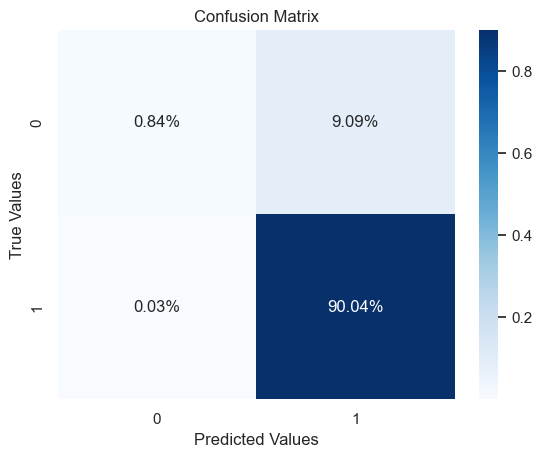

******************************




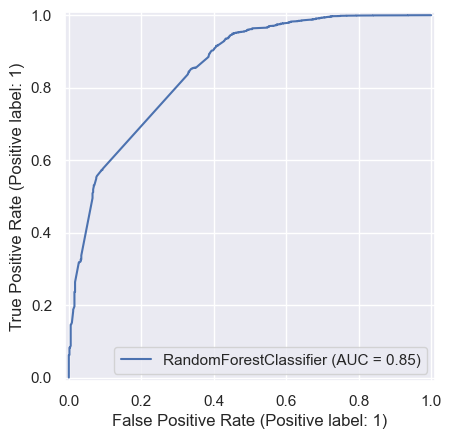

In [82]:
# Train and Predict the Test Labels
y_pred_class  = rf_modebuilder.train_model()
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)

### **5. XGBoost**

In [83]:
xgclf = xgb.XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42) #based on the tuned parameters
xg_modebuilder = ModelFactory(xgclf, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 94.2%
Precision is : 94.5%
Recall is : 99.3%
F1 Score is : 96.9%
Roc-Auc Score is:92.6%
******************************


              precision    recall  f1-score   support

           0       0.88      0.48      0.62       581
           1       0.95      0.99      0.97      5270

    accuracy                           0.94      5851
   macro avg       0.91      0.74      0.80      5851
weighted avg       0.94      0.94      0.93      5851

******************************




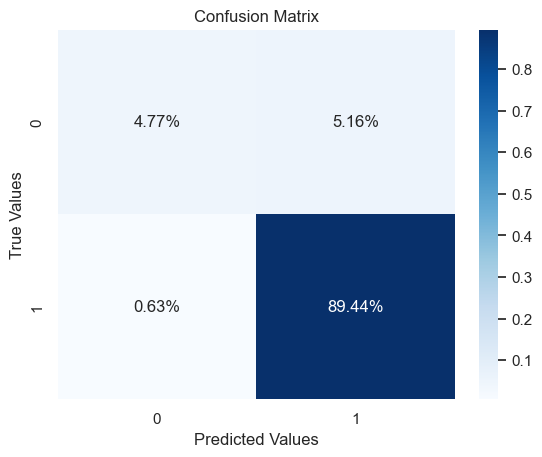

******************************




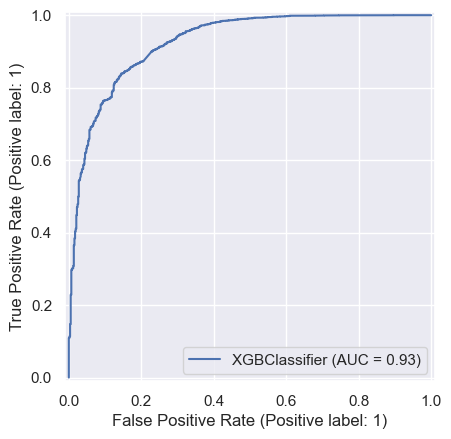

In [84]:
# Train and Predict the Test Labels
y_pred_class  = xg_modebuilder.train_model()
xg_metrics = xg_modebuilder.evaluate_model(y_pred_class)

#### **Model Inference**

In [85]:
# Creating a table which contain all the metrics
metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score','Auc Score'], 
        'Logistic Regression': lr_metrics,
        'Naive Bayes': nb_metrics,
        'Decision Tree': dt_metrics_cv,
         'Random Forrest': rf_metrics,
        'XG Boost': xg_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 
                                                    'Naive Bayes','Decision Tree','Random Forrest', 'XG Boost'] )

df_metrics

,Metric,Logistic Regression,Naive Bayes,Decision Tree,Random Forrest,XG Boost
0,Accuracy,0.89,0.93,0.93,0.91,0.94
1,Precision,0.98,0.93,0.94,0.91,0.95
2,Recall,0.90,1.00,0.99,1.00,0.99
3,F1Score,0.94,0.96,0.96,0.95,0.97
4,Auc Score,0.93,0.91,0.79,0.85,0.93


Comparing the above models on the metrics, XG Boost looks to be a better model, saving the XG Boost model as a pickle file for later us

In [86]:
save_object_to_pickle(xgclf, 'sentiment-classification-xg-boost-model')

Object successfully saved to: pickle_files\sentiment-classification-xg-boost-model.pkl


# **Task 5: Building the Recommendation System**

Need to evalute and choose one between these two recommendation system
- User-based recommendation system
- Item-based recommendation system

In [87]:
cl_df = pd.read_pickle("pickle_files/preprocessed-dataframe.pkl")
cl_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_preprocess_text,reviews_complete_text
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",others,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,1,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome love hip hop side current pop SO listen everyday give rating metaphor
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",others,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,1,Good Good flavor. This review was collected as part of a promotion.,Good Good This review collect part
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",others,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09 00:00:00+00:00,5,Good flavor.,Good,dorothy w,1,Good Good flavor.,Good Good
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",others,K-Y Love Sensuality Pleasure Gel,2016-01-06 00:00:00+00:00,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was ...",Disappointed,rebecca,0,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vase...",Disappointed I read review look buy one couple ultimately disappointed even live review I For neither boyfriend I could notice sort enhance What messy consistency reminiscent It difficult clean especially since lack sensation disappoint I pay much I lube I use I could use normal personal lubricant less money less
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",others,K-Y Love Sensuality Pleasure Gel,2016-12-21 00:00:00+00:00,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,0,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation My husband buy gel The gel cause irritation felt like burn I recommend


72 rows with either unknow `review_title` or unknown `reviews_username`

In [88]:
cl_df[(cl_df["reviews_title"] == "unknown") | (cl_df["reviews_username"] == "unknown")].shape

(72, 13)

In [89]:
user_recommendation_df_columns = ['id', 'name', 'reviews_rating', 'reviews_username']
user_recommendation_df = cl_df[user_recommendation_df_columns]
user_recommendation_df.head()

,id,name,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557


### **Dividing the data in train and test**

In [90]:
train, test = train_test_split(user_recommendation_df, test_size=0.30, random_state=42)

In [91]:
print(train.shape)
print(test.shape)

(20478, 4)
(8777, 4)


In [92]:
user_recommendation_df_pivot = train.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)
user_recommendation_df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfF7k8ilAPnD_xUyWf,AVpfFGqP1cnluZ0-ddjG,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6b

### **Creating dummy train and test**
These dataset will be used for prediction:
- Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset.
- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [93]:
# Copy the train dataset into dummy_train
recommendation_user_dummy_train = train.copy()

In [94]:
# The products not rated by user is marked as 1 for prediction.
recommendation_user_dummy_train['reviews_rating'] = recommendation_user_dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [95]:
# Convert the dummy train dataset into matrix format
recommendation_user_dummy_train = recommendation_user_dummy_train.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(1)
recommendation_user_dummy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfF7k8ilAPnD_xUyWf,AVpfFGqP1cnluZ0-ddjG,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6b

## **User Based Recommendation System**
### **User Similarity Matrix**
**Using adjusted Cosine** <br/>

In [96]:
# Create Pivot the train ratings data into matrix
# In this case columns are Products and the rows are usernames.
user_recommendation_df_pivot = train.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
user_recommendation_df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfF7k8ilAPnD_xUyWf,AVpfFGqP1cnluZ0-ddjG,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6b

In [97]:
mean = np.nanmean(user_recommendation_df_pivot, axis=1)
user_recommendation_df_subtracted = (user_recommendation_df_pivot.T-mean).T
user_recommendation_df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfF7k8ilAPnD_xUyWf,AVpfFGqP1cnluZ0-ddjG,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6b

In [98]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(user_recommendation_df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### **User-User Prediction**

We will predict ratings for a user by considering only those users who have a positive correlation with the target user. Users with negative correlations are excluded as they are less similar to the target user. By focusing on positively correlated users, we can make more accurate predictions based on similar preferences.


In [99]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).

In [100]:
user_predicted_ratings = np.dot(user_correlation, user_recommendation_df_pivot.fillna(0))
print(user_predicted_ratings.shape)
user_predicted_ratings

(17790, 218)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [101]:
user_final_rating = np.multiply(user_predicted_ratings,recommendation_user_dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfF7k8ilAPnD_xUyWf,AVpfFGqP1cnluZ0-ddjG,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6b

In [102]:
save_object_to_pickle(user_final_rating, "user_final_rating")

Object successfully saved to: pickle_files\user_final_rating.pkl


# **Task 6: Recommendation of Top 20 Products to a Specified User `User-User`**

In [103]:
user_input = "08dallas"

In [104]:
recommendations_user_user = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations_user_user

id
AV13O1A8GV-KLJ3akUyj    0.0
AVpfPPkEilAPnD_xX3cP    0.0
AVpfN6Z71cnluZ0-gZmO    0.0
AVpfNVsj1cnluZ0-gNQN    0.0
AVpfNWbPilAPnD_xXPR7    0.0
AVpfNfEMLJeJML434uf-    0.0
AVpfNglu1cnluZ0-gQ7x    0.0
AVpfO5u71cnluZ0-guiN    0.0
AVpfOIrkilAPnD_xXgDG    0.0
AVpfOfIqLJeJML435D06    0.0
AVpfOmKwLJeJML435GM7    0.0
AVpfOrD0ilAPnD_xXrRj    0.0
AVpfPKzxLJeJML435SYL    0.0
AVpfPaoqLJeJML435Xk9    0.0
AVpfUCiPilAPnD_xZai4    0.0
AVpfPjqKLJeJML435aZR    0.0
AVpfPkrkilAPnD_xX-L9    0.0
AVpfPnrU1cnluZ0-g9rL    0.0
AVpfPx6V1cnluZ0-hA5y    0.0
AVpfQtEm1cnluZ0-hUpe    0.0
Name: 08dallas, dtype: float64

In [105]:
#display the top 20 product id, name and similarity_score 
final_recommendations_user = pd.DataFrame({'product_id': recommendations_user_user.index, 'similarity_score' : recommendations_user_user})
final_recommendations_user.reset_index(drop=True)
pd.merge(final_recommendations_user, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),0.0
1,AVpfPPkEilAPnD_xX3cP,"Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",0.0
187,AVpfN6Z71cnluZ0-gZmO,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",0.0
228,AVpfNVsj1cnluZ0-gNQN,"Physicians Formula Powder Palette Mineral Glow Pearls, Translucent Pearl",0.0
234,AVpfNWbPilAPnD_xXPR7,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",0.0
242,AVpfNfEMLJeJML434uf-,Heiress (dvd),0.0
244,AVpfNglu1cnluZ0-gQ7x,Mia Shower Curtain Green/brown - Lush Decor174,0.0
251,AVpfO5u71cnluZ0-guiN,Switchmas (dvd),0.0
257,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),0.0
363,AVpfOfIqLJeJML435D06,Solo Foods Poppy Seed Cake and Pastry Filling,0.0


In [106]:
def get_top_recommendation_users(users):
    new_df = pd.DataFrame()
    for user_input in users:
        try:
            temp_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
            temp = temp_recommendations.to_frame().reset_index()
            temp = temp[temp.columns.difference(['id'])].T
            temp.columns = [f"product{ind}" for ind in range(len(temp.columns))]
            temp.insert(0, "user", user_input)
            
            if len(new_df) != 0:
                new_df = pd.concat([new_df, temp], ignore_index=True, axis=0)
            else:
                new_df = temp

        except:
            continue

    return new_df

In [107]:
temp_user_recommendation_df = get_top_recommendation_users(train.reviews_username.unique())

In [108]:
save_object_to_pickle(temp_user_recommendation_df.sort_values(by=["product0"], ascending=False).head(10), "best_recommendation_users")

Object successfully saved to: pickle_files\best_recommendation_users.pkl


#### **Users with best product recommendations**

In [109]:
temp_user_recommendation_df.sort_values(by=["product0"], ascending=False).head(10)

,user,product0,product1,product2,product3,product4,product5,product6,product7,product8,product9,product10,product11,product12,product13,product14,product15,product16,product17,product18,product19
6151,manny,74.55,30.28,26.67,13.25,13.18,11.50,9.55,7.08,5.38,5.02,4.90,4.55,4.14,3.73,3.69,3.33,3.26,3.26,3.26,3.08
1449,moerena,74.07,21.82,19.07,19.03,16.62,10.04,10.02,8.70,8.41,7.80,7.20,5.61,4.89,4.66,4.12,3.89,3.89,3.87,3.79,3.45
2769,nana,70.58,56.69,49.41,31.32,16.12,13.98,11.32,10.73,10.26,9.91,9.31,9.24,8.89,8.44,7.78,7.76,7.01,7.00,6.84,6.60
1275,vicki,70.39,57.65,43.62,34.72,13.21,11.15,10.05,9.05,8.97,8.82,8.58,8.01,7.99,7.68,6.60,5.65,5.21,5.19,5.16,5.09
2988,viewer,68.30,57.01,47.63,39.36,30.82,13.13,11.45,10.19,9.92,8.96,8.72,8.48,8.43,8.37,7.82,7.38,7.28,5.34,4.83,4.48
2010,brandon,68.18,54.46,42.29,30.39,30.36,11.00,10.19,9.61,8.81,8.81,8.69,7.93,7.78,7.41,7.28,6.81,5.83,5.74,5.32,5.16
3171,ronnie,67.86,48.29,31.75,29.58,13.73,11.38,10.70,9.57,9.57,8.72,8.40,8.29,8.19,7.85,7.83,7.77,7.62,7.34,7.09,6.73
3896,thom,66.53,53.03,48.62,41.48,30.70,12.85,11.50,11.07,10.23,9.26,9.17,8.95,8.42,8.31,7.34,6.98,6.61,6.45,6.41,6.22
9535,chas,66.53,53.03,48.62,41.48,30.70,12.85,11.50,11.07,10.23,9.26,9.17,8.95,8.42,8.31,7.34,6.98,6.61,6.45,6.41,6.22
505,adam,66.10,45.85,40.22,29.46,29.38,12.34,10.98,10.71,9.45,8.97,8.86,8.72,8.51,8.23,7.34,7.27,7.09,6.98,6.82,6.61


#### **Evaluation User-User**

In [110]:
# Find out the common users of test and train dataset.
common_users = test[test.reviews_username.isin(train.reviews_username)]
common_users.shape

(1892, 4)

In [111]:
common_users.head()

,id,name,reviews_rating,reviews_username
19958,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,mommy2three
8516,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,angie0104
18684,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,4,babe
21876,AVpfMpZ51cnluZ0-f_L9,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,5,alexis
25458,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,5,ross


In [112]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"

# # convert into the user-movie matrix.
common_user_based_matrix = pd.pivot_table(common_users,index=user_column, columns = product_column, values = value_column)
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe9W4D1cnluZ0-avf0,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBrUZilAPnD_xTUly,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfcu821cnluZ0-k8ep,AVpfgvkJLJeJML43-g1y,AVpfkak01cnluZ0-nJj6,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrfHF1cnluZ0-pRai,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23jen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [113]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,17540,17541,17542,17543,17544,17545,17546,17547,17548,17549,17550,17551,17552,17553,17554,17555,17556,17557,17558,17559,17560,17561,17562,17563,17564,17565,17566,17567,17568,17569,17570,17571,17572,17573,17574,17575,17576,17577,17578,17579,17580,17581,17582,17583,17584,17585,17586,17587,17588,17589,17590,17591,17592,17593,17594,17595,17596,17597,17598,17599,17600,17601,17602,17603,17604,17605,17606,17607,17608,17609,17610,17611,17612,17613,17614,17615,17616,17617,17618,17619,17620,17621,17622,17623,17624,17625,17626,17627,17628,17629,17630,17631,17632,17633,17634,17635,17636,17637,17638,17639,17640,17641,17642,17643,17644,17645,17646,17647,17648,17649,17650,17651,17652,17653,17654,17655,17656,17657,17658,17659,17660,17661,17662,17663,17664,17665,17666,17667,17668,17669,17670,17671,17672,17673,17674,17675,17676,17677,17678,17679,17680,17681,17682,17683,17684,17685,17686,17687,17688,17689,17690,17691,17692,17693,17694,17695,17696,17697,17698,17699,17700,17701,17702,17703,17704,17705,17706,17707,17708,17709,17710,17711,17712,17713,17714,17715,17716,17717,17718,17719,17720,17721,17722,17723,17724,17725,17726,17727,17728,17729,17730,17731,17732,17733,17734,17735,17736,17737,17738,17739,17740,17741,17742,17743,17744,17745,17746,17747,17748,17749,17750,17751,17752,17753,17754,17755,17756,17757,17758,17759,17760,17761,17762,17763,17764,17765,17766,17767,17768,17769,17770,17771,17772,17773,17774,17775,17776,17777,17778,17779,17780,17781,17782,17783,17784,17785,17786,17787,17788,17789
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [114]:
user_correlation_df[user_column] = user_recommendation_df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,17540,17541,17542,17543,17544,17545,17546,17547,17548,17549,17550,17551,17552,17553,17554,17555,17556,17557,17558,17559,17560,17561,17562,17563,17564,17565,17566,17567,17568,17569,17570,17571,17572,17573,17574,17575,17576,17577,17578,17579,17580,17581,17582,17583,17584,17585,17586,17587,17588,17589,17590,17591,17592,17593,17594,17595,17596,17597,17598,17599,17600,17601,17602,17603,17604,17605,17606,17607,17608,17609,17610,17611,17612,17613,17614,17615,17616,17617,17618,17619,17620,17621,17622,17623,17624,17625,17626,17627,17628,17629,17630,17631,17632,17633,17634,17635,17636,17637,17638,17639,17640,17641,17642,17643,17644,17645,17646,17647,17648,17649,17650,17651,17652,17653,17654,17655,17656,17657,17658,17659,17660,17661,17662,17663,17664,17665,17666,17667,17668,17669,17670,17671,17672,17673,17674,17675,17676,17677,17678,17679,17680,17681,17682,17683,17684,17685,17686,17687,17688,17689,17690,17691,17692,17693,17694,17695,17696,17697,17698,17699,17700,17701,17702,17703,17704,17705,17706,17707,17708,17709,17710,17711,17712,17713,17714,17715,17716,17717,17718,17719,17720,17721,17722,17723,17724,17725,17726,17727,17728,17729,17730,17731,17732,17733,17734,17735,17736,17737,17738,17739,17740,17741,17742,17743,17744,17745,17746,17747,17748,17749,17750,17751,17752,17753,17754,17755,17756,17757,17758,17759,17760,17761,17762,17763,17764,17765,17766,17767,17768,17769,17770,17771,17772,17773,17774,17775,17776,17777,17778,17779,17780,17781,17782,17783,17784,17785,17786,17787,17788,17789
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [115]:
list_name = common_users.reviews_username.tolist()

user_correlation_df.columns = user_recommendation_df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [116]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T

In [117]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [118]:
recommendation_user_dummy_test = common_users.copy()

recommendation_user_dummy_test[value_column] = recommendation_user_dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
recommendation_user_dummy_test = pd.pivot_table(recommendation_user_dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)


In [119]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe9W4D1cnluZ0-avf0,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBrUZilAPnD_xTUly,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfcu821cnluZ0-k8ep,AVpfgvkJLJeJML43-g1y,AVpfkak01cnluZ0-nJj6,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrfHF1cnluZ0-pRai,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23jen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [120]:
recommendation_user_dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe9W4D1cnluZ0-avf0,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBrUZilAPnD_xTUly,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfcu821cnluZ0-k8ep,AVpfgvkJLJeJML43-g1y,AVpfkak01cnluZ0-nJj6,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrfHF1cnluZ0-pRai,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23jen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [121]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,recommendation_user_dummy_test)
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe9W4D1cnluZ0-avf0,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBrUZilAPnD_xTUly,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfcu821cnluZ0-k8ep,AVpfgvkJLJeJML43-g1y,AVpfkak01cnluZ0-nJj6,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrfHF1cnluZ0-pRai,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23jen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

**Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.**

In [122]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [123]:
common_users_ = pd.pivot_table(common_users, index = user_column, columns = product_column, values = value_column)

In [124]:
total_non_nan = np.count_nonzero(~np.isnan(y))

#### **RMSE of `User-User`**

In [125]:
rmse_user_user = (sum(sum((common_users_ - y )**2))/total_non_nan)**0.5
print(rmse_user_user)

2.3931530272458366


## **Item Based Recommendation System**

### **Item Similarity Matrix**

In [126]:
item_recommendation_df_pivot = train.pivot_table(index='reviews_username', columns='id',values='reviews_rating').T
item_recommendation_df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,1.11E+24,1085,1143mom,11677j,1234,1234561,1234567,123cat123,123charlie,123numbers,123rs,123too,127726,12cass12,12gage,132457,13dani,13ld,13ram,1421nikki,143st,148maine,1515,15425shopper,1616,170361eggs,1753,17roses,1943,1950rmm,1970,1979edes,1992firebirdgirl,19granny,1awesome1,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1disappoint,1friendlycat,1glenn,1gra,1happymom,1healthytot,1hotmama,1jodie,1movielover2,1nikki31t,1officegal,1okc2thunder3up4,1olaygal,1pleasedclient,1scooby1,1sonny,1stgrade,1stlady,1sttimemama,1sungirl,1texasmom,1tomg,2011mom2b,2011pink2011,2014bestbuys,2015mom,2062351337,20crafter16,210tundra,2175046722,21honey,232323,23jen,24hrstoneroses,2532674594,25happyshopper,262jennifer,2689,2827,28green,295259,2athome,2bgreen,2big,2busy4u,2ds4es14,2esinapod,2forhokies,2go4savings,2iceskates,2rogersmakearight,2sweetdaisies,2thumbsup,2total,2w0cat5z,2xmom,30103,3276teev,3375509742,370gt,37f5p,38redsox,3babiesat41,3bear,3bees,3boys2turtles5chicks,3card,3dcav,3dfan,3dknights,3dmoviewatcher,3dpic,3lilones,3littlegirls,3ringbandb,3scissors,4 rooms 1 dog lotsa fur,405april,4112,44pam44,45177ss,45cleanupwoman,45mindishqueen,49erfaithful,49ersfor6,4cloroxl,4djs,4dogmom,4frugal,4gis1975,4katelyn,4momma88,4my5goldens,4parman,4shop,4stew57,4th grade teacher,4theloveofclorox,500mpl,50cal,5150seriousshopper5150,530germkiller,54867906,551580,57susie,5mcdaniels,5star414,5zenuff,6211958,62deuce,64falcon,6623443094,67firebird,69chopper,6mex2,6utefans,7.87E+11,70chp,70cohoosier,714reginald,714rv,72443,7737593842,79captm79,7autumn5,7frances7,7inthenest,7rick,80021mom,80204,8023,808wrx,81t21,85721747267,8574178605,85lisa,8675309,88brit06,89c46698305f04e39d57a88a2c5c3ce297787288,8bithero,8ellie24,8mooshu,8thred,9003058363,911notimetoshop,9373weld,987654321abc,98nd500,99runner,9thdoctor,_christenak,a hutch,a leaf on the family tree,a1126,a11mxdup,a1s3,a77077,a786,a7xmaddlove,aaaa,aaam,aac06002,aac3,aakon,aalyah,aaron,aaronabigail,aaronlab,aaronm,aaube1990,ab45,ab86,ababe,abacadaba,abam,abarker1215,abartine,abashli,abberdoodlesmom,abbey,abbey64,abbi,abbs77,abbuyguy,abby,abby11,abby132,abby8992,abbysmama,abc,abc1245,abc3,abc4sb206,abcd,abcdef,abcdefghij,abcssds,abctech,abd1,abear93,abefroman,abel9027,abelc,...,workingmomof1,worm,wormgang,wow this conditioner,wowiezowie,wownostreaks,wowwie,wrat,wreckzu,wren113,wrigleysmom,writerstone,wsnug,wspeedracerz28,wsweetie,wvcleaning,wvdeb56,wvpcollins,wvshopaholic,wvu1,wwphf,wxyz,wyatt,wyatt09,wylynn,wynn,wyoshopgril,xanadu72,xander126,xavenger,xavier,xaviersmommy110311,xbox,xbox1gamer,xboxlover,xcanuck,xcartersmommyx,xcelerate,xcoach98,xcoupon,xcrisstanicolex,xenawp,xeon500cc,xgivanx,xhillbill,xiaodan z,xl,xlivayy,xman,xman5969,xmas,xmen1234,xmom,xnrcr3,xolisa,xolittlebit,xplnusa,xpotatotitsx,xqhinc,xracer,xraymom,xsbluesugar,xsnitro,xstr8edgex,xtinaa01,xtony,xxacw12xx,xxfloridagirlxx,xxyy,xyzmom,xzxsarahzxz,yagerbomb07,yago,yaii,yama,yamel97,yams2536,yana,yang,yangko,yani,yankee23,yankeegirl15,yankees,yankees500,yanks,yanks2k14,yappingpuppy,yaquiv,yard12,yardguy,yardleysmother,yarethv,yari1,yary27,yassi,yata32,yayatex,yazt,yazzmiin,ybadilla,ybeard,ycyc,ydteoo,yeag350,yeeya,yeknom,yelley,yellow,yes22,yes2carrotslover,yesman,yesseniaw22,yessi,yessi819,yeya,yeyo,yg007,yglesias99,ygtz,yharkins,yiayiamre,yj45,ymdunn,ymontes923,yneis,yoad78,yoadrian,yoamomovies,yodas64,yoganicmommy,yogip,yognap,yogore,yogurt,yohnie1,yoko76,yolanda,yolandas,yoli36,yolonda24,yolyrn,yonino,yonoegwa,yoolie,yooper,yopack,yorissa,yorkie6,yorkielvr,yorkster88,yosh,yoshi,yoski,yosuerte,youjon,youknowhowitgoes,younggrannie62,youronereviewer,youthfulone,yoyo1245,yozer29,ypryor,yrina03,yshan,yttric,yucky111,yummy,yumyum,yunji,yvonne,yyz2112123,yzkgsx,z992,zabdelra,zacharymcneill,zacharysaunt,zachsmom,zaibo,zakkwylde29,zakkzakk,zanarkandruinsx2,zapman,zara0215,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zee74,zegan,zenanuts,zenmon,zer0ze

In [127]:
mean = np.nanmean(item_recommendation_df_pivot, axis=1)
item_recommendation_df_subtracted = (item_recommendation_df_pivot.T-mean).T
item_recommendation_df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,1.11E+24,1085,1143mom,11677j,1234,1234561,1234567,123cat123,123charlie,123numbers,123rs,123too,127726,12cass12,12gage,132457,13dani,13ld,13ram,1421nikki,143st,148maine,1515,15425shopper,1616,170361eggs,1753,17roses,1943,1950rmm,1970,1979edes,1992firebirdgirl,19granny,1awesome1,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1disappoint,1friendlycat,1glenn,1gra,1happymom,1healthytot,1hotmama,1jodie,1movielover2,1nikki31t,1officegal,1okc2thunder3up4,1olaygal,1pleasedclient,1scooby1,1sonny,1stgrade,1stlady,1sttimemama,1sungirl,1texasmom,1tomg,2011mom2b,2011pink2011,2014bestbuys,2015mom,2062351337,20crafter16,210tundra,2175046722,21honey,232323,23jen,24hrstoneroses,2532674594,25happyshopper,262jennifer,2689,2827,28green,295259,2athome,2bgreen,2big,2busy4u,2ds4es14,2esinapod,2forhokies,2go4savings,2iceskates,2rogersmakearight,2sweetdaisies,2thumbsup,2total,2w0cat5z,2xmom,30103,3276teev,3375509742,370gt,37f5p,38redsox,3babiesat41,3bear,3bees,3boys2turtles5chicks,3card,3dcav,3dfan,3dknights,3dmoviewatcher,3dpic,3lilones,3littlegirls,3ringbandb,3scissors,4 rooms 1 dog lotsa fur,405april,4112,44pam44,45177ss,45cleanupwoman,45mindishqueen,49erfaithful,49ersfor6,4cloroxl,4djs,4dogmom,4frugal,4gis1975,4katelyn,4momma88,4my5goldens,4parman,4shop,4stew57,4th grade teacher,4theloveofclorox,500mpl,50cal,5150seriousshopper5150,530germkiller,54867906,551580,57susie,5mcdaniels,5star414,5zenuff,6211958,62deuce,64falcon,6623443094,67firebird,69chopper,6mex2,6utefans,7.87E+11,70chp,70cohoosier,714reginald,714rv,72443,7737593842,79captm79,7autumn5,7frances7,7inthenest,7rick,80021mom,80204,8023,808wrx,81t21,85721747267,8574178605,85lisa,8675309,88brit06,89c46698305f04e39d57a88a2c5c3ce297787288,8bithero,8ellie24,8mooshu,8thred,9003058363,911notimetoshop,9373weld,987654321abc,98nd500,99runner,9thdoctor,_christenak,a hutch,a leaf on the family tree,a1126,a11mxdup,a1s3,a77077,a786,a7xmaddlove,aaaa,aaam,aac06002,aac3,aakon,aalyah,aaron,aaronabigail,aaronlab,aaronm,aaube1990,ab45,ab86,ababe,abacadaba,abam,abarker1215,abartine,abashli,abberdoodlesmom,abbey,abbey64,abbi,abbs77,abbuyguy,abby,abby11,abby132,abby8992,abbysmama,abc,abc1245,abc3,abc4sb206,abcd,abcdef,abcdefghij,abcssds,abctech,abd1,abear93,abefroman,abel9027,abelc,...,workingmomof1,worm,wormgang,wow this conditioner,wowiezowie,wownostreaks,wowwie,wrat,wreckzu,wren113,wrigleysmom,writerstone,wsnug,wspeedracerz28,wsweetie,wvcleaning,wvdeb56,wvpcollins,wvshopaholic,wvu1,wwphf,wxyz,wyatt,wyatt09,wylynn,wynn,wyoshopgril,xanadu72,xander126,xavenger,xavier,xaviersmommy110311,xbox,xbox1gamer,xboxlover,xcanuck,xcartersmommyx,xcelerate,xcoach98,xcoupon,xcrisstanicolex,xenawp,xeon500cc,xgivanx,xhillbill,xiaodan z,xl,xlivayy,xman,xman5969,xmas,xmen1234,xmom,xnrcr3,xolisa,xolittlebit,xplnusa,xpotatotitsx,xqhinc,xracer,xraymom,xsbluesugar,xsnitro,xstr8edgex,xtinaa01,xtony,xxacw12xx,xxfloridagirlxx,xxyy,xyzmom,xzxsarahzxz,yagerbomb07,yago,yaii,yama,yamel97,yams2536,yana,yang,yangko,yani,yankee23,yankeegirl15,yankees,yankees500,yanks,yanks2k14,yappingpuppy,yaquiv,yard12,yardguy,yardleysmother,yarethv,yari1,yary27,yassi,yata32,yayatex,yazt,yazzmiin,ybadilla,ybeard,ycyc,ydteoo,yeag350,yeeya,yeknom,yelley,yellow,yes22,yes2carrotslover,yesman,yesseniaw22,yessi,yessi819,yeya,yeyo,yg007,yglesias99,ygtz,yharkins,yiayiamre,yj45,ymdunn,ymontes923,yneis,yoad78,yoadrian,yoamomovies,yodas64,yoganicmommy,yogip,yognap,yogore,yogurt,yohnie1,yoko76,yolanda,yolandas,yoli36,yolonda24,yolyrn,yonino,yonoegwa,yoolie,yooper,yopack,yorissa,yorkie6,yorkielvr,yorkster88,yosh,yoshi,yoski,yosuerte,youjon,youknowhowitgoes,younggrannie62,youronereviewer,youthfulone,yoyo1245,yozer29,ypryor,yrina03,yshan,yttric,yucky111,yummy,yumyum,yunji,yvonne,yyz2112123,yzkgsx,z992,zabdelra,zacharymcneill,zacharysaunt,zachsmom,zaibo,zakkwylde29,zakkzakk,zanarkandruinsx2,zapman,zara0215,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zee74,zegan,zenanuts,zenmon,zer0ze

**Cosine similarity using pairwise distances approach**

In [128]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(item_recommendation_df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


**correlation only for which the value is greater than 0. (Positively correlated)**

In [129]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### **Prediction - `Item-Item`**

In [130]:
item_predicted_ratings = np.dot((item_recommendation_df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.01190255, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00364662, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00911654, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00729323, 0.        ,
        0.        ]])

#### **Filtering the rating only for the products not rated by the user for recommendation**

In [131]:
item_final_rating = np.multiply(item_predicted_ratings, recommendation_user_dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfA5BeLJeJML430eOi,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBuqY1cnluZ0-cTBI,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfCy9b1cnluZ0-cqWS,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDflP1cnluZ0-c5RJ,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfE7puilAPnD_xUcCW,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfF7k8ilAPnD_xUyWf,AVpfFGqP1cnluZ0-ddjG,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfHZMxLJeJML432tfs,AVpfHf4wLJeJML432vqK,AVpfIGFeLJeJML4328YR,AVpfIN84LJeJML432_D9,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6b

# **Task 6: Recommendation of Top 20 Products to a Specified User `Item-Item`**

In [132]:
recommendations_item_item = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations_item_item

id
AVpe9W4D1cnluZ0-avf0    1.59e-01
AVpe5c23LJeJML43xybi    5.59e-02
AVpe7GIELJeJML43yZfu    4.99e-02
AVpfluP1ilAPnD_xejxO    4.12e-02
AVpf2tw1ilAPnD_xjflC    2.14e-02
AVpf0eb2LJeJML43EVSt    2.09e-02
AVpf385g1cnluZ0-s0_t    1.66e-02
AVpe31o71cnluZ0-YrSD    1.62e-02
AVpfR5m0LJeJML436K3W    5.47e-03
AV1l8zRZvKc47QAVhnAv    4.96e-03
AVpfRTh1ilAPnD_xYic2    3.06e-03
AVpe41TqilAPnD_xQH3d    1.56e-03
AVpfOrD0ilAPnD_xXrRj    0.00e+00
AV13O1A8GV-KLJ3akUyj    0.00e+00
AVpfPPkEilAPnD_xX3cP    0.00e+00
AVpfOmKwLJeJML435GM7    0.00e+00
AVpfOfIqLJeJML435D06    0.00e+00
AVpfOIrkilAPnD_xXgDG    0.00e+00
AVpfPKzxLJeJML435SYL    0.00e+00
AVpfPx6V1cnluZ0-hA5y    0.00e+00
Name: 08dallas, dtype: float64

In [133]:
#display the top 20 product id, name and similarity_score 
final_recommendations_item = pd.DataFrame({'product_id': recommendations_item_item.index, 'similarity_score' : recommendations_item_item})
final_recommendations_item.reset_index(drop=True)
pd.merge(final_recommendations_item, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpe9W4D1cnluZ0-avf0,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,1.59e-01
163,AVpe5c23LJeJML43xybi,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,5.59e-02
185,AVpe7GIELJeJML43yZfu,Eagle Fat Free Sweetened Condensed Milk,4.99e-02
194,AVpfluP1ilAPnD_xejxO,Stacy's Simply Naked Bagel Chips,4.12e-02
210,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),2.14e-02
666,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),2.09e-02
1273,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",1.66e-02
1412,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),1.62e-02
1578,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,5.47e-03
1726,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,4.96e-03


#### **Best recommended users - item recommendation**

In [134]:
def get_top_recommendation_items(users):
    new_df = pd.DataFrame()
    for user_input in users:
        try:
            temp_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
            temp = temp_recommendations.to_frame().reset_index()
            temp = temp[temp.columns.difference(['id'])].T
            temp.columns = [f"product{ind}" for ind in range(len(temp.columns))]
            temp.insert(0, "user", user_input)
            
            if len(new_df) != 0:
                new_df = pd.concat([new_df, temp], ignore_index=True, axis=0)
            else:
                new_df = temp

        except:
            continue

    return new_df

In [135]:
temp_item_recommendation_df = get_top_recommendation_items(train.reviews_username.unique())

In [136]:
temp_item_recommendation_df.sort_values(by=["product0"], ascending=False).head(10)

,user,product0,product1,product2,product3,product4,product5,product6,product7,product8,product9,product10,product11,product12,product13,product14,product15,product16,product17,product18,product19
8151,dfwatheartgirl,1.84,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
504,cdguerrero,1.84,0.02,0.02,0.01,9.19e-03,4.06e-03,2.46e-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
1991,gelon33,1.84,0.02,0.02,0.01,9.19e-03,4.06e-03,2.46e-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
4649,rayray,1.84,0.73,0.24,0.03,2.48e-02,2.35e-02,1.92e-02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,9.62e-03,9.37e-03,9.15e-03,9.12e-03,8.52e-03,8.18e-03
1757,kimmicha,1.84,0.02,0.02,0.01,9.19e-03,4.06e-03,2.46e-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
8110,coupongirl63301,1.84,0.02,0.02,0.01,9.19e-03,4.06e-03,2.46e-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
10921,traviemom,1.84,0.02,0.02,0.01,9.19e-03,4.06e-03,2.46e-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
14687,violagirl522,1.84,0.02,0.02,0.01,9.19e-03,4.06e-03,2.46e-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
10920,momandteacher,1.84,0.02,0.02,0.01,9.19e-03,4.06e-03,2.46e-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
13944,purple22,1.84,0.02,0.02,0.01,9.19e-03,4.06e-03,2.46e-03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00


#### **Evaluation - Item Item**
Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user.

In [137]:
common_items = test[test['id'].isin(train['id'])]
print(common_items.shape)
common_items.head()

(8759, 4)


,id,name,reviews_rating,reviews_username
10776,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,brant
27425,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),4,kingsixx
1019,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),5,grangolfer
21235,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,rohzgirl
14861,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,soccermom1


#### **Item Based Matrix**

In [138]:
common_item_based_matrix =  common_items.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T
common_item_based_matrix.shape

(158, 8181)

In [139]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.14e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.23e-03,1.00e-03,0.0,0.0,6.04e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.04e-03,0.0,0.0,0.0,6.97e-03,0.0,0.0,0.0,0.0,2.84e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.16e-03,0.0,0.0,0.0,1.

In [140]:
item_correlation_df['productId'] = item_recommendation_df_subtracted.index
item_correlation_df.set_index('productId',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0

In [141]:
item_correlation_df.columns = item_recommendation_df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(common_items['id'].tolist())]

In [142]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(common_items['id'].tolist())]
item_correlation_df_3 = item_correlation_df_2.T

In [143]:
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7fFbilAPnD_xkrmW,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfDiTDLJeJML431Y21,AVpfELcXLJeJML431naf,AVpfEqFbilAPnD_xUV28,AVpfEqruilAPnD_xUWDr,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHI2filAPnD_xVL7R,AVpfIGFeLJeJML4328YR,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6sF1cnluZ0-nmwC,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.00e+00,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0

In [144]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02415616, 0.        , 0.00532649, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03037509, 0.        , ..., 0.        , 0.00911654,
        0.05062516],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [145]:
dummy_test_recommendation = common_items.copy()
dummy_test_recommendation['reviews_rating'] = dummy_test_recommendation['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test_recommendation = dummy_test_recommendation.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)


In [146]:
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test_recommendation)

**The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.**

In [147]:
common_items_ = common_items.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [148]:
X  = common_item_predicted_ratings.copy()
X = X[X>0]

# Applying MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [149]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [150]:
rmse_item_item = (sum(sum((common_items_ - y )**2))/total_non_nan)**0.5
print(rmse_item_item)

3.5701485985345913


### **Selecting Best Recommendation Model:**

In [151]:
print("RMSE of User Based Recommendation System: ", rmse_user_user)
print("RMSE of Item Based Recommendation System: ", rmse_item_item)

RMSE of User Based Recommendation System:  2.3931530272458366
RMSE of Item Based Recommendation System:  3.5701485985345913


On comparing the RMSE values of User Based Recommender and Item Based Recommender, User based recommendation model seems to be better in this case, as it has a lower RMSE value (~2.3). <br/>
#### **`User User Recommendation` system is chosen**.

## **Improving the recommendations using the sentiment analysis model**

### Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

#### Load the cleaned dataframe

In [152]:
clean_df = pd.read_pickle("pickle_files/preprocessed-dataframe.pkl")
clean_df_recommended = clean_df[['id','name','reviews_complete_text', 'user_sentiment']]

#### Load the user final rating

In [153]:
user_final_rating = pd.read_pickle("pickle_files/user_final_rating.pkl")

In [154]:
user_input = "rebecca"

# **Task 6:Recommendation of Top 20 Products to a Specified User**

In [155]:
def get_top20_products_for_user(user):
    # get the top 20  recommedation using the user_final_rating
    top20_reco = user_final_rating.loc[user].sort_values(ascending=False)[0:20]
    recommendations = pd.DataFrame({'product_id': top20_reco.index, 'similarity_score' : top20_reco})
    recommendations.reset_index(drop=True)
    result = pd.merge(recommendations, clean_df_recommended, on="id")[["id", "name", "similarity_score"]].drop_duplicates()
    
    return result

In [156]:
get_top20_products_for_user(user_input)

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,29.59
3325,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),10.67
3994,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),9.87
4662,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,9.47
6701,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),8.45
7458,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,6.62
7722,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",6.54
8032,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,5.49
8204,AVpf63aJLJeJML43F__Q,"Burt's Bees Lip Shimmer, Raisin",4.74
9077,AVpe6FfKilAPnD_xQmHi,Chex Muddy Buddies Brownie Supreme Snack Mix,4.20


# **Task 7: Fine-Tuning the Recommendation System and Recommendation of Top 5 Products**

### Fine tune and optimise the recommendation using the user-recommendation and classification model

In [157]:
class User_Recommendation:
    def __init__(self):
       
        self.clean_df = pd.read_pickle("pickle_files/preprocessed-dataframe.pkl")
        self.clean_df_recommended = self.clean_df[['id','name','reviews_complete_text', 'user_sentiment']]

        self.user_final_rating = pd.read_pickle("pickle_files/user_final_rating.pkl")

        file = open("pickle_files/tfidf-vectorizer.pkl",'rb')
        self.vectorizer = pickle.load(file)
        file.close()

        # XGBoost
        file = open("pickle_files/sentiment-classification-xg-boost-model.pkl",'rb')
        self.model = pickle.load(file)
        file.close()

    def get_top5_user_recommendations(self, user):
        if user in self.user_final_rating.index:
            # get the top 20  recommedation using the user_final_rating
            top20_reco = list(self.user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
            # get the product recommedation using the orig data used for trained model
            common_top20_reco = self.clean_df_recommended[self.clean_df['id'].isin(top20_reco)]
            # Apply the TFIDF Vectorizer for the given 20 products to convert data in reqd format for modeling
            X =  self.vectorizer.transform(common_top20_reco['reviews_complete_text'].values.astype(str))

            # Using the model from param to predict
            # self.model.set_test_data(X)
            common_top20_reco['sentiment_pred']= self.model.predict(X)

            # Create a new dataframe "pred_df" to store the count of positive user sentiments
            temp_df = common_top20_reco.groupby(by='name').sum()
            # Create a new dataframe "pred_df" to store the count of positive user sentiments
            sent_df = temp_df[['sentiment_pred']]
            sent_df.columns = ['positive_sentiment_count']
            # Create a column to measure the total sentiment count
            sent_df['total_sentiment_count'] = common_top20_reco.groupby(by='name')['sentiment_pred'].count()
            # Calculate the positive sentiment percentage
            sent_df['positive_sentiment_percent'] = np.round(sent_df['positive_sentiment_count']/sent_df['total_sentiment_count']*100,2)
            # Return top 5 recommended products to the user
            result = sent_df.sort_values(by='positive_sentiment_percent', ascending=False)[:5]
            return result
        else:
            print(f"User name {user} doesn't exist")


def get_top5_recommendationsNew(user):
    user_recommendation = User_Recommendation()
    recommendation_df = user_recommendation.get_top5_user_recommendations(user=user).reset_index()
    result = recommendation_df.to_dict("records")
    print(result)
    return result

In [158]:
get_top5_recommendationsNew('rebecca')

[{'name': 'Ragu Roasted Garlic Parmesan Pasta Sauce', 'positive_sentiment_count': 22, 'total_sentiment_count': 22, 'positive_sentiment_percent': 100.0}, {'name': 'Chex Muddy Buddies Brownie Supreme Snack Mix', 'positive_sentiment_count': 29, 'total_sentiment_count': 29, 'positive_sentiment_percent': 100.0}, {'name': 'Jolly Time Select Premium Yellow Pop Corn', 'positive_sentiment_count': 27, 'total_sentiment_count': 27, 'positive_sentiment_percent': 100.0}, {'name': 'Clorox Disinfecting Bathroom Cleaner', 'positive_sentiment_count': 2028, 'total_sentiment_count': 2039, 'positive_sentiment_percent': 99.46}, {'name': 'The Resident Evil Collection 5 Discs (blu-Ray)', 'positive_sentiment_count': 838, 'total_sentiment_count': 845, 'positive_sentiment_percent': 99.17}]


[{'name': 'Ragu Roasted Garlic Parmesan Pasta Sauce',
  'positive_sentiment_count': 22,
  'total_sentiment_count': 22,
  'positive_sentiment_percent': 100.0},
 {'name': 'Chex Muddy Buddies Brownie Supreme Snack Mix',
  'positive_sentiment_count': 29,
  'total_sentiment_count': 29,
  'positive_sentiment_percent': 100.0},
 {'name': 'Jolly Time Select Premium Yellow Pop Corn',
  'positive_sentiment_count': 27,
  'total_sentiment_count': 27,
  'positive_sentiment_percent': 100.0},
 {'name': 'Clorox Disinfecting Bathroom Cleaner',
  'positive_sentiment_count': 2028,
  'total_sentiment_count': 2039,
  'positive_sentiment_percent': 99.46},
 {'name': 'The Resident Evil Collection 5 Discs (blu-Ray)',
  'positive_sentiment_count': 838,
  'total_sentiment_count': 845,
  'positive_sentiment_percent': 99.17}]